# Convolutional Neural Networks for Image Classification
Code adapted from the tutorial found [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?fbclid=IwAR3oCSoNwG3e4cCiEJjtiiolT9hMuJJDI9wVjbfGsFIAlzJuu9NC1UnfRxI).



## Import Modules and Data

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from random import randint
import math
from torch.optim import lr_scheduler #.MultiStepLR

In [2]:
# define transformation operation for corpus
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download trainset, init dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# download testset, init dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# define possible classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# define device as GPU (if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Define a Convolutional Neural Network

In [4]:
# define exception to be thrown when illegal hyperparameters are entered
class HyperparameterError(Exception):
  """ Exception raised for errors in the input hyperparameters

      Attributes:
        expression -- input expression in which the error occurred
        message -- explanation of the error
  """

  def __init__(self, message):
    self.message = message
    print(self.message)

In [5]:
def calc_Hout(h_in_size, padding, dilation, kernel_size, stride):
  pad = 2 * padding
  dil_ker = (kernel_size - 1) * dilation
  numerator = h_in_size + pad - dil_ker - 1
  denom = stride
  frac = numerator / denom
  hout = math.floor(frac + 1)
  return hout

def calc_Wout(w_in_size, padding, dilation, kernel_size, stride):
  pad = 2 * padding
  dil_ker = (kernel_size - 1) * dilation
  numerator = w_in_size + pad - dil_ker - 1
  denom = stride
  frac = numerator / denom
  wout = math.floor(frac + 1)
  return wout

In [6]:
# Implements ConvNet Class

class ConvNet(nn.Module):
  # Initiates the network
  # Different from tutorial in that it allows you to pass in hyperparameters
  #   in order to make it easier to run experiments


  def __init__(self, 
               num_convs=2, 
               num_linears=3, 
               dims=[32, 16, 120, 84], 
               kernel_sizes=[5,5], 
               pool=True,
               pool_kernel_size=2,
               pool_stride=2, 
               padding=2,
               dilation=1,
               stride=1):
    super(ConvNet, self).__init__()
    # OTHER HYPERPARAMS TO LOOK INTO:
        # Conv: stride, padding, (padding_mode), dilation, bias
        # Linear: bias
        # Pool: padding, dilation, ceil_mode

    # set input values as attributes
    self.num_convs = num_convs
    self.num_linears = num_linears
    self.dims = dims
    self.kernel_sizes = kernel_sizes
    self.pool = pool
    self.pool_kernel_size = pool_kernel_size
    self.pool_stride = pool_stride
    self.padding = padding
    self.dilation = dilation
    self.stride = stride

    hout_size = 0
    wout_size = 0

    
    # HYPERPARAM VALIDITY CHECKS
    num_layers = num_convs + num_linears
    if len(dims) != num_layers - 1:
      raise HyperparameterError(message="ERROR: Mismatching dimensions and number of layers")

    if num_convs <= 0 or num_linears <= 0:
      raise HyperparameterError(message="ERROR: Need at least one conv layer and at least one linear layer.")

    if num_convs != len(kernel_sizes) and len(kernel_sizes) != 1:
      raise HyperparameterError(message="ERROR: Kernel Sizes are not constant and do not match number of Conv layers.")
    elif len(kernel_sizes) == 1:
      kernels = [kernel_sizes[0]] * num_convs
      print("kernels:", kernels)
    else:
      kernels = kernel_sizes
    self.kernels = kernels

    # GENERATE LAYERS
    # Generate Conv Layers
    conv_list = []
    w_in = dims[0]
    h_in = dims[0]
    h_out = 0
    w_out = 0
    for i in range(num_convs):
      # define number of input channels for current layer
      if i == 0:
        # If is the first layer, then automatically has 3 input channels
        in_channels = 3
      else:
        in_channels = dims[i-1]
      # define number of output channels, kernel size for current layer
      out_channels = dims[i]
      kernel_size = kernels[i]

      # instantiate current conv layer
      curr_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, dilation=self.dilation, stride=self.stride)
      
      # calc and store Hout and Wout sizes
      h_out = calc_Hout(h_in, self.padding, self.dilation, self.kernels[i], self.stride)
      w_out = calc_Wout(w_in, self.padding, self.dilation, self.kernels[i], self.stride)

      # print("\n\nh_out:", h_out, "w_out:", w_out)

      if h_out < 1 or w_out < 1:
        raise HyperparameterError(message="ERROR: Hidden size or weights size goes to 0.")
      
      # if i+1 < len(kernels):
      if h_out < kernels[i] or w_out < kernels[i]:
        raise HyperparameterError(message="ERROR: Hidden layer size is less than kernel size at conv layer %s."%(i))

      # append curr layer to conv list
      conv_list.append(curr_conv)

      # print("in:%s, padding:%s, dilation:%s, kernel_size:%s, stride:%s"%(curr_conv.in_channels, curr_conv.padding[0], curr_conv.dilation[0], curr_conv.kernel_size[0], curr_conv.stride[0]))
      # print("in:%s, padding:%s, dilation:%s, kernel_size:%s, stride:%s"%(curr_conv.in_channels, curr_conv.padding[1], curr_conv.dilation[1], curr_conv.kernel_size[1], curr_conv.stride[1]))

      h_out = calc_Hout(curr_conv.in_channels, curr_conv.padding[0], curr_conv.dilation[0], curr_conv.kernel_size[0], curr_conv.stride[0])
      w_out = calc_Wout(curr_conv.in_channels, curr_conv.padding[1], curr_conv.dilation[1], curr_conv.kernel_size[1], curr_conv.stride[1])

      if pool:
        h_out = calc_Hout(h_out, padding=0, dilation=1, kernel_size=self.pool_kernel_size, stride=self.pool_stride)
        w_out = calc_Wout(w_out, padding=0, dilation=1, kernel_size=self.pool_kernel_size, stride=self.pool_stride)
      # print("h_o:", h_out)
      # print("w_o:", w_out)

    # assign conv_list as an attribute
    self.conv_list = conv_list

    l_in = h_out * w_out / math.pow(4, (self.num_convs-1)) # size of hidden in * weights in / batch size (4)

    # Generate Linear Layers
    linear_list = []
    for i in range(num_linears):
      # define input size for current layer
      if i == 0:
        in_size = dims[num_convs + i - 1] * int(l_in)
        print("in_size:",in_size)
      else:
        in_size = dims[num_convs + i - 1]
      # define size of output for current layer
      if i == num_linears - 1:
        # If is last layer, output needs to be 10 (number of classes)
        out_size = 10
      else:
        out_size = dims[num_convs + i]
      # instantiate current linear layer and add to linear list
      curr_linear = nn.Linear(in_size, out_size)
      linear_list.append(curr_linear)
    
    # assign linear list as an attribute
    self.linear_list = linear_list

    # If pool=True, generate a pool layer
    if pool:
      self.maxpool = nn.MaxPool2d(pool_kernel_size, pool_stride)
      # assign the generated parameters to the network's parameter list
    
    full_layers = conv_list + linear_list

    for i in range(len(full_layers)):
      curr_layer = full_layers[i]
      print(curr_layer)
      if i < len(conv_list):
        name = "conv" + str(i+1)
      else:
        name = "linear" + str(i - len(conv_list) + 1)
      exec("self.%s=layer"%(name), {'self': self, 'layer':curr_layer})

  




  def forward(self, x0):
    for i in range(self.num_convs):
      name = "conv" + str(i+1)
      prev_data_name = 'x' + str(i)
      # exec(compile("print(%s.shape)"%(prev_data_name), 'ftest', 'exec'))
      next_data_name = 'x' + str(i + 1)
      code = compile("%s = self.maxpool(F.relu(self.%s(%s)))" %(next_data_name, name, prev_data_name), 'f1', 'exec') #, {'x0':x0,'self.pool':self.pool, 'relu':F.relu, 'self':self})
      exec(code)

    last_conv_name = 'x' + str(self.num_convs)
    # exec(compile("print(%s.shape)"%(last_conv_name), 'fi2', 'exec'))
    code = compile("l0 = %s.view(4, int(self.linear1.in_features))"%(last_conv_name), 'f2', 'exec')
    exec(code)
    # exec(compile("print(x1.shape)", 'fi', 'exec'))
    # exec(compile("print(l0.shape)", 'fi', 'exec'))

    for i in range(self.num_linears):
      name = "linear" + str(i+1)
      prev_data_name = 'l' + str(i)
      next_data_name = 'l' + str(i + 1)
      if i != self.num_linears - 1:
        code = compile("%s = F.relu(self.%s(%s))"%(next_data_name, name, prev_data_name), 'f3', 'exec')
        exec(code)
      else:
        code = compile("model_out = self.%s(%s)"%(name, prev_data_name), 'f4', 'exec')
        exec(code)
    return(eval(compile("model_out", 'retrn', 'eval')))

## Implement Experiment Pipeline

In [7]:
# Params list, keeping everything constant except for the number of different layers
params = {
    'num_convs': [2],
    'num_linears': [3],
    'conv_dim': [32],
    'linear_dim': [128],
    'kernel_sizes': [5],
    'pool': [True],
    'pool_kernel_size': [2],
    'pool_stride': [2]
}

In [23]:
def run_experiment(params, NUM_EPOCHS):
  num_convs_list = params['num_convs']
  num_linears_list = params['num_linears']

  model_dict = {}
  acc_dict = {}

  # iterate through network sizes
  for conv_num in num_convs_list:
    for linear_num in num_linears_list:
      # initialize key for model in accuracy_dict
      k = (conv_num, linear_num)
      print("\n\nCURR SETTING IS:\nNum conv layers:",k[0],"\nNum linear layers:",k[1])

      conv_dims = params['conv_dim'] * conv_num
      linear_dims = params['linear_dim'] * int(linear_num-1)

      # init conv net with defined parameters
      convnet = ConvNet(
          num_convs=conv_num,
          num_linears=linear_num,
          dims = conv_dims + linear_dims,
          kernel_sizes = params['kernel_sizes'],
          pool = params['pool'][0],
          pool_kernel_size = params['pool_kernel_size'][0],
          pool_stride = params['pool_stride'][0]
          )
      print(convnet.parameters())
      
      # put instantiated network onto the GPU
      convnet.to(device)

      # define loss function
      criterion = nn.CrossEntropyLoss()
      # define optimizer
      # optimizer = optim.SGD(convnet.parameters(), lr=0.001, momentum=0.9)
      optimizer = optim.Adam(convnet.parameters(), lr=0.001)
      scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15,20], gamma=0.1)
        
      # TRAIN!

      # for loop for epochs
      for epoch in range(NUM_EPOCHS):
        acc_list = []
        # reset loss to 0 at start of each epoch
        running_loss = 0.0

        # iterate through data
        for i, data in enumerate(trainloader, 0):
          # load inputs and labels from dataloader, put on GPU
          inputs, labels = data[0].to(device), data[1].to(device)

          # print("inp:",inputs.shape)
          # print("labels:",labels.shape)
          # reset gradients to zero
          optimizer.zero_grad()

          # forward pass
          outputs = convnet(inputs)
          # print("outp:",outputs.shape)
          # calculate the loss based on the outputs and ground truth
          loss = criterion(outputs, labels)
          # calculate the gradients throughout the network 
          loss.backward()
          # update weights based on the gradients
          optimizer.step()

          # count up loss
          running_loss += loss.item()
          # every 2000 steps, print average loss and zero out running loss
          if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch +1, i+1, running_loss / 2000))
            running_loss = 0.0
        # update the scheduler (update learning rate if at milestone)
        scheduler.step()
        correct = 0
        total = 0
        # don't update gradients (leftover from pytorch implementation, does nothing now)
        with torch.no_grad():
          # iterate through test dataset
          for data in trainloader:
            # load test data, put on GPU
            images, labels = data[0].to(device), data[1].to(device)
            # get outputs
            outputs = convnet(images)
            # predict category based on outputs
            _, predicted = torch.max(outputs.data, 1)
            # increase total number of labels by number of instances seen in this batch
            total += labels.size(0)
            # increase number of correct predicitons by number of correct predictions in this batch
            correct += (predicted == labels).sum().item()
        # calc and print overall model accuracy
        acc = 100 * correct / total
        acc_list.append(acc)
        print('Accuracy of the network on train images: %f %%' % (acc))
      
        correct = 0
        total = 0
        # don't update gradients
        with torch.no_grad():
          # iterate through test dataset
          for data in testloader:
            # load test data, put on GPU
            images, labels = data[0].to(device), data[1].to(device)
            # get outputs
            outputs = convnet(images)
            # predict category based on outputs
            _, predicted = torch.max(outputs.data, 1)

            # increase total number of labels by number of instances seen in this batch
            total += labels.size(0)
            # increase number of correct predicitons by number of correct predictions in this batch
            correct += (predicted == labels).sum().item()
        # calc and print overall model accuracy
        acc = 100 * correct / total
        acc_list.append(acc)
        print('Accuracy of the network on test images: %f %%' % (acc))

        acc_dict[epoch] = acc_list

      print('Finished Training')

      # PREDICT AND CALCULATE ACCURACY
      # count number of correct and number of total
      correct = 0
      total = 0
      # don't update gradients
      with torch.no_grad():
        # iterate through test data
          for data in testloader:
            # load test data, put on GPU
            images, labels = data[0].to(device), data[1].to(device)
            # get outputs
            outputs = convnet(images)
            # predict category based out outputs
            _, predicted = torch.max(outputs.data, 1)
            # increase total number of labels by number of instances seen in this batch
            total += labels.size(0)
            # increase number of correct predicitons by number of correct predictions in this batch
            correct += (predicted == labels).sum().item()
      # calculate and print overall model accuracy
      acc = 100 * correct / total
      print('Accuracy of the network on the 10000 test images: %f %%' % (acc))

      # add model and accuracy to model_dict
      model_dict[k] = [convnet, acc]

  print(model_dict)
  print(acc_dict)
  return acc_dict

In [24]:
acc_dict = run_experiment(params, NUM_EPOCHS=20)



CURR SETTING IS:
Num conv layers: 2 
Num linear layers: 3
kernels: [5, 5]
in_size: 2048
Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Linear(in_features=2048, out_features=128, bias=True)
Linear(in_features=128, out_features=128, bias=True)
Linear(in_features=128, out_features=10, bias=True)
<generator object Module.parameters at 0x7f87d155e7d8>
[1,  2000] loss: 1.803
[1,  4000] loss: 1.539
[1,  6000] loss: 1.418
[1,  8000] loss: 1.355
[1, 10000] loss: 1.298
[1, 12000] loss: 1.258
Accuracy of the network on train images: 60.326000 %
Accuracy of the network on test images: 57.870000 %
[2,  2000] loss: 1.155
[2,  4000] loss: 1.158
[2,  6000] loss: 1.125
[2,  8000] loss: 1.114
[2, 10000] loss: 1.110
[2, 12000] loss: 1.091
Accuracy of the network on train images: 63.024000 %
Accuracy of the network on test images: 59.830000 %
[3,  2000] loss: 0.999
[3,  4000] loss: 1.019
[3,  6000] loss: 1.004
[3,  8000]

{0: [60.326, 57.87], 1: [63.024, 59.83], 2: [69.24, 64.15], 3: [69.824, 63.87], 4: [71.298, 64.63], 5: [79.412, 70.0], 6: [80.504, 70.42], 7: [81.9, 70.36], 8: [82.92, 70.53], 9: [83.782, 70.07], 10: [84.386, 70.52], 11: [84.59, 70.52], 12: [84.69, 70.48], 13: [84.808, 70.5], 14: [84.896, 70.52], 15: [84.988, 70.49], 16: [84.986, 70.51], 17: [85.006, 70.55], 18: [85.006, 70.51], 19: [85.018, 70.48]}


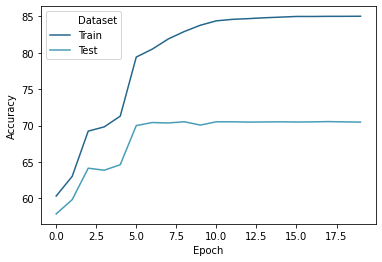

In [25]:
# code for graphing epochs vs acc for train vs. test
import seaborn as sns
import pandas as pd


datalist = []

for key in acc_dict.keys():
  currlist_train = [key, acc_dict[key][0], 'Train']
  datalist.append(currlist_train)
  currlist_test = [key, acc_dict[key][1], 'Test']
  datalist.append(currlist_test)

acc_df = pd.DataFrame(datalist, columns=['Epoch', 'Accuracy', 'Dataset'])
print(acc_dict)

g = sns.lineplot(x="Epoch", y="Accuracy", hue="Dataset", palette="YlGnBu_d", data=acc_df)

In [25]:
# DON'T RERUN OR DELETE THIS!!!
acc_dict = run_experiment(params, NUM_EPOCHS=120)



CURR SETTING IS:
Num conv layers: 2 
Num linear layers: 3
kernels: [5, 5]
in_size: 2048
Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Linear(in_features=2048, out_features=128, bias=True)
Linear(in_features=128, out_features=128, bias=True)
Linear(in_features=128, out_features=10, bias=True)
<generator object Module.parameters at 0x7f81f0cc0b48>
[1,  2000] loss: 1.790
[1,  4000] loss: 1.518
[1,  6000] loss: 1.412
[1,  8000] loss: 1.347
[1, 10000] loss: 1.288
[1, 12000] loss: 1.288
Accuracy of the network on train images: 58.938000 %
Accuracy of the network on test images: 57.870000 %
[2,  2000] loss: 1.176
[2,  4000] loss: 1.160
[2,  6000] loss: 1.135
[2,  8000] loss: 1.133
[2, 10000] loss: 1.126
[2, 12000] loss: 1.111
Accuracy of the network on train images: 62.210000 %
Accuracy of the network on test images: 59.410000 %
[3,  2000] loss: 1.013
[3,  4000] loss: 1.035
[3,  6000] loss: 1.038
[3,  8000]

{0: [58.938, 57.87],
 1: [62.21, 59.41],
 2: [68.818, 64.75],
 3: [68.284, 64.09],
 4: [70.366, 65.41],
 5: [71.808, 66.14],
 6: [76.094, 68.44],
 7: [75.8, 67.51],
 8: [76.624, 66.96],
 9: [75.496, 66.19],
 10: [78.064, 67.61],
 11: [79.94, 67.49],
 12: [78.062, 65.92],
 13: [79.788, 67.62],
 14: [81.322, 67.29],
 15: [81.836, 67.17],
 16: [82.152, 67.31],
 17: [84.06, 67.59],
 18: [83.022, 67.09],
 19: [83.262, 66.81],
 20: [84.368, 67.05],
 21: [85.846, 67.39],
 22: [84.916, 67.58],
 23: [86.832, 67.77],
 24: [87.754, 67.49],
 25: [86.086, 67.07],
 26: [87.882, 67.35],
 27: [86.848, 66.39],
 28: [87.922, 67.42],
 29: [85.608, 65.82],
 30: [88.98, 66.95],
 31: [88.638, 67.39],
 32: [90.178, 67.62],
 33: [88.702, 67.04],
 34: [87.08, 65.88],
 35: [86.166, 65.71],
 36: [89.308, 66.41],
 37: [89.796, 66.39],
 38: [88.928, 66.32],
 39: [90.988, 67.69],
 40: [87.458, 65.46],
 41: [87.876, 66.39],
 42: [91.898, 67.36],
 43: [91.006, 66.7],
 44: [91.764, 67.2],
 45: [76.716, 60.63],
 46: [9